In [2]:
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
from scipy.stats import pearsonr 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from math import sqrt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

2024-03-28 13:18:31.364629: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional

# USDC Univariate LSTM Time Series

Approximately 2,000 samples

In [4]:
def json_to_prices(json):
    df = pd.read_json(json)
    prices = df['prices']
    coin_prices = pd.DataFrame(prices.tolist(), columns=['time', 'price'])
    prices = coin_prices['price']
    return prices

In [100]:
prices = json_to_prices('time_series_modeling/data/usdc90days.json')

In [5]:
def normalize_prices(prices):
    normalized_prices = (prices - np.mean(prices)) / np.std(prices)
    return normalized_prices

In [102]:
# Normalize the prices data
normalized_prices = (prices - np.mean(prices)) / np.std(prices)
print(normalized_prices)

0       0.313974
1      -0.139964
2      -0.707387
3      -0.026480
4      -1.274809
          ...   
2155   -2.977077
2156   -0.026480
2157    0.540943
2158   -1.501778
2159    0.087005
Name: price, Length: 2160, dtype: float64


In [6]:
def split_data(normalized_prices, split=0.8):
    train_size = int(len(normalized_prices) * split)
    test_size = len(normalized_prices) - train_size
    
    training_data = normalized_prices[0:train_size]
    test_data = normalized_prices[train_size:len(normalized_prices)]
    return training_data, test_data

In [7]:
def create_dataset_helper(data, time_step=1):
    X, y = [], []
    data = data.reset_index(drop=True)

    for i in range(len(data) - time_step):      
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

In [8]:
def create_dataset(data, time_steps=1):
    X, y = create_dataset_helper(data, time_steps)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    return X, y

In [106]:
time_step = 10 # the number of time steps you're looking at to predict the next step.

# Split the data into training and testing data
training_data, test_data = split_data(normalized_prices)
X_train, y_train = create_dataset(training_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [107]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1718, 10, 1) (1718,) (422, 10, 1) (422,)


In [9]:
def create_model():
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [109]:
model = create_model()
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 10, 50)            10400     
                                                                 
 lstm_28 (LSTM)              (None, 50)                20200     
                                                                 
 dense_17 (Dense)            (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [110]:
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
54/54 [==============================] - 4s 8ms/step - loss: 0.9145
Epoch 2/50
54/54 [==============================] - 0s 7ms/step - loss: 0.9109
Epoch 3/50
54/54 [==============================] - 0s 6ms/step - loss: 0.9112
Epoch 4/50
54/54 [==============================] - 0s 7ms/step - loss: 0.9122
Epoch 5/50
54/54 [==============================] - 0s 7ms/step - loss: 0.9107
Epoch 6/50
54/54 [==============================] - 0s 6ms/step - loss: 0.9097
Epoch 7/50
54/54 [==============================] - 0s 9ms/step - loss: 0.9076
Epoch 8/50
54/54 [==============================] - 0s 7ms/step - loss: 0.9112
Epoch 9/50
54/54 [==============================] - 0s 6ms/step - loss: 0.9076
Epoch 10/50
54/54 [==============================] - 0s 8ms/step - loss: 0.9088
Epoch 11/50
54/54 [==============================] - 0s 7ms/step - loss: 0.9080
Epoch 12/50
54/54 [==============================] - 0s 8ms/step - loss: 0.9063
Epoch 13/50
54/54 [==============================

In [10]:
def predictions(model, X_train, y_train, X_test, y_test, prices):
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    train_predict = (train_predictions * np.std(prices)) + np.mean(prices)
    y_train = (y_train * np.std(prices)) + np.mean(prices)
    test_predict = (test_predictions * np.std(prices)) + np.mean(prices)
    y_test = (y_test * np.std(prices)) + np.mean(prices)
    
    train_score = sqrt(mean_squared_error(y_train, train_predict))
    print('Train Score: %.20f RMSE' % (train_score))
    test_score = sqrt(mean_squared_error(y_test, test_predict))
    print('Test Score: %.20f RMSE' % (test_score))
    print('Test Predictions: ' + str(test_predict))
    return train_predict, test_predict
    

In [11]:
def plot_time_series(train_predict, test_predict, prices, time_step=10):
    train_predict_flattened = train_predict.flatten()
    test_predict_flattened = test_predict.flatten()
    train_size = len(train_predict)
    test_size = len(test_predict)
    
    plt.figure(figsize=(10, 6))
    plt.plot(prices, color='blue', label='Actual Price')
    plt.plot(range(time_step, train_size + time_step), train_predict_flattened, color='green', label='Train Predicted Price')
    plt.plot(range(train_size + time_step, train_size + time_step + test_size), test_predict_flattened, color='red', label='Test Predicted Price')

    plt.title('USDC Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
 

In [83]:
train_predict, test_predict = predictions(model, X_train, y_train, X_test, y_test, prices)

14/14 [==============================] - 0s 3ms/step
Train Score: 0.00079637113500502553 RMSE
Test Score: 0.00107860277806733876 RMSE


In [88]:
# flatten the predictions
train_predict_flattened = train_predict.flatten()
test_predict_flattened = test_predict.flatten()
train_size = len(train_predict)
test_size = len(test_predict)

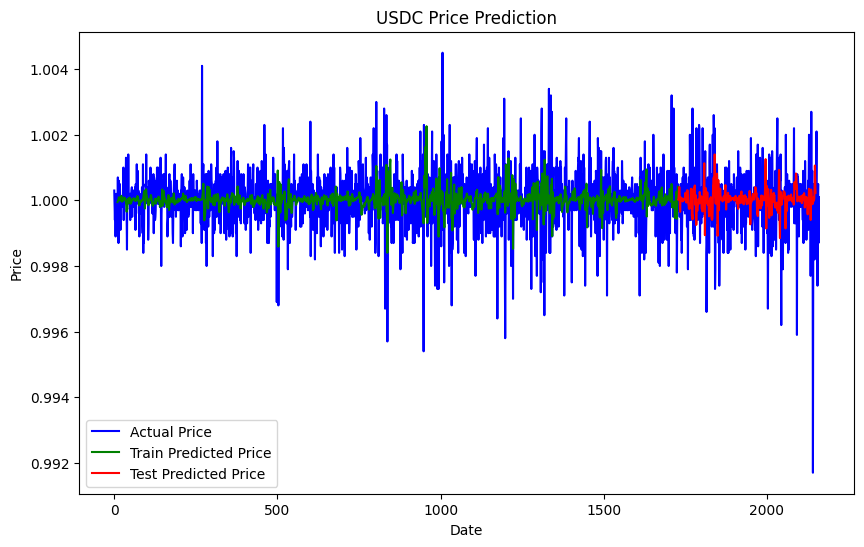

In [89]:
# graph the results

# reshape train_predict and test_predict to the shape of prices

plt.figure(figsize=(10, 6))
plt.plot(prices, color='blue', label='Actual Price')
plt.plot(range(time_step, train_size + time_step), train_predict_flattened, color='green', label='Train Predicted Price')
plt.plot(range(train_size + time_step, train_size + time_step + test_size), test_predict_flattened, color='red', label='Test Predicted Price')

plt.title('USDC Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Ethereum Univariate LSTM Time Series

In [90]:
time_step = 10

prices = json_to_prices('time_series_modeling/data/ethereum90days.json')
normalized_prices = normalize_prices(prices)
training_data, test_data = split_data(normalized_prices)
X_train, y_train = create_dataset(training_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
lstm = create_model()

lstm.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))


Epoch 1/50
54/54 [==============================] - 5s 19ms/step - loss: 0.0631 - val_loss: 0.4438
Epoch 2/50
54/54 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.3967
Epoch 3/50
54/54 [==============================] - 0s 7ms/step - loss: 0.0104 - val_loss: 0.3468
Epoch 4/50
54/54 [==============================] - 0s 8ms/step - loss: 0.0095 - val_loss: 0.3417
Epoch 5/50
54/54 [==============================] - 0s 7ms/step - loss: 0.0087 - val_loss: 0.2704
Epoch 6/50
54/54 [==============================] - 0s 7ms/step - loss: 0.0082 - val_loss: 0.3184
Epoch 7/50
54/54 [==============================] - 0s 7ms/step - loss: 0.0071 - val_loss: 0.2737
Epoch 8/50
54/54 [==============================] - 0s 7ms/step - loss: 0.0064 - val_loss: 0.3184
Epoch 9/50
54/54 [==============================] - 0s 7ms/step - loss: 0.0061 - val_loss: 0.3040
Epoch 10/50
54/54 [==============================] - 0s 7ms/step - loss: 0.0057 - val_loss: 0.3021
Epoch 11/50
54/54 

In [95]:
train_predict, test_predict = predictions(lstm, X_train, y_train, X_test, y_test, prices)

14/14 [==============================] - 0s 3ms/step
Train Score: 12.76268769449559137286 RMSE
Test Score: 86.21029180163651517432 RMSE
Test Predictions: [[2488.8237]
 [2489.7744]
 [2492.1084]
 [2492.4563]
 [2491.6953]
 [2485.3828]
 [2491.7234]
 [2494.125 ]
 [2506.98  ]
 [2509.8015]
 [2499.4124]
 [2498.521 ]
 [2500.404 ]
 [2505.5698]
 [2505.3398]
 [2524.4731]
 [2516.536 ]
 [2522.0706]
 [2526.793 ]
 [2525.4949]
 [2524.1443]
 [2521.4954]
 [2522.284 ]
 [2529.119 ]
 [2522.0342]
 [2512.281 ]
 [2513.636 ]
 [2509.808 ]
 [2508.1272]
 [2511.3687]
 [2513.061 ]
 [2507.6558]
 [2494.8992]
 [2503.034 ]
 [2499.9927]
 [2506.53  ]
 [2510.8645]
 [2513.7188]
 [2499.916 ]
 [2499.9434]
 [2493.5818]
 [2494.4343]
 [2494.689 ]
 [2499.9507]
 [2489.9353]
 [2475.6155]
 [2478.4546]
 [2485.1587]
 [2490.219 ]
 [2485.4392]
 [2524.5818]
 [2555.8179]
 [2550.343 ]
 [2596.2617]
 [2612.0056]
 [2608.84  ]
 [2630.2007]
 [2623.7869]
 [2648.3276]
 [2648.2678]
 [2656.2158]
 [2664.6245]
 [2647.7605]
 [2632.1816]
 [2637.9517]
 

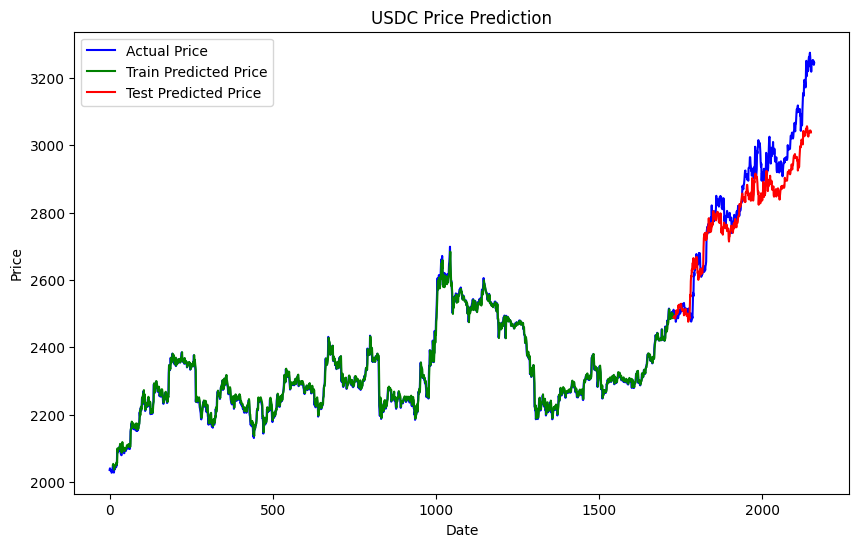

In [96]:
# plot 

plot_time_series(train_predict, test_predict, prices, time_step)

# Ethereum LSTM with Simpler Model

In [58]:
def create_simple_model():
    model = Sequential()
    model.add(LSTM(50, return_sequences=False, input_shape=(time_step, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [59]:
time_step = 10

prices = json_to_prices('time_series_modeling/data/ethereum90days.json')
normalized_prices = normalize_prices(prices)
training_data, test_data = split_data(normalized_prices)
X_train, y_train = create_dataset(training_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
lstm = create_simple_model()

lstm.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
54/54 [==============================] - 2s 13ms/step - loss: 0.0956 - val_loss: 1.0740
Epoch 2/50
54/54 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.4862
Epoch 3/50
54/54 [==============================] - 0s 5ms/step - loss: 0.0095 - val_loss: 0.4951
Epoch 4/50
54/54 [==============================] - 0s 6ms/step - loss: 0.0091 - val_loss: 0.3924
Epoch 5/50
54/54 [==============================] - 0s 5ms/step - loss: 0.0085 - val_loss: 0.3311
Epoch 6/50
54/54 [==============================] - 0s 6ms/step - loss: 0.0080 - val_loss: 0.3657
Epoch 7/50
54/54 [==============================] - 0s 5ms/step - loss: 0.0074 - val_loss: 0.2554
Epoch 8/50
54/54 [==============================] - 0s 5ms/step - loss: 0.0068 - val_loss: 0.2423
Epoch 9/50
54/54 [==============================] - 0s 4ms/step - loss: 0.0063 - val_loss: 0.2203
Epoch 10/50
54/54 [==============================] - 0s 4ms/step - loss: 0.0059 - val_loss: 0.2657
Epoch 11/50
54/54 

In [60]:
predictions(lstm, X_train, y_train, X_test, y_test, prices)

14/14 [==============================] - 0s 2ms/step
Train Score: 12.93506077759598937860 RMSE
Test Score: 39.55521056366510634916 RMSE


(array([[2041.107 ],
        [2045.6344],
        [2038.0079],
        ...,
        [2487.3074],
        [2485.089 ],
        [2495.3975]], dtype=float32),
 array([[2486.7808],
        [2488.7065],
        [2490.9014],
        [2491.4893],
        [2490.7468],
        [2484.7961],
        [2489.8682],
        [2492.8525],
        [2504.9849],
        [2509.0496],
        [2499.5737],
        [2497.6113],
        [2499.324 ],
        [2504.2512],
        [2504.61  ],
        [2522.2424],
        [2517.1318],
        [2521.176 ],
        [2526.2485],
        [2525.4683],
        [2524.0107],
        [2521.469 ],
        [2521.8997],
        [2528.2495],
        [2522.7588],
        [2513.0017],
        [2512.9724],
        [2509.8086],
        [2507.7402],
        [2510.4253],
        [2512.4375],
        [2507.8076],
        [2495.6687],
        [2501.181 ],
        [2499.6091],
        [2505.056 ],
        [2509.883 ],
        [2513.0103],
        [2500.7383],
        [2499.0317],
    

In [66]:
# testing model on 2022 data

time_step = 10
prices = json_to_prices('time_series_modeling/data/ethereum90days.json')
training_data = normalize_prices(prices)
X_train, y_train = create_dataset(training_data, time_step)

test_prices = json_to_prices('time_series_modeling/data/ethereum2022test.json')
test_data = normalize_prices(test_prices)

X_test, y_test = create_dataset(test_data, time_step)
lstm = create_model()

lstm.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
68/68 [==============================] - 4s 16ms/step - loss: 0.1202 - val_loss: 2.7086
Epoch 2/50
68/68 [==============================] - 0s 6ms/step - loss: 0.0148 - val_loss: 2.5249
Epoch 3/50
68/68 [==============================] - 0s 6ms/step - loss: 0.0117 - val_loss: 2.4865
Epoch 4/50
68/68 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 2.4594
Epoch 5/50
68/68 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 2.3772
Epoch 6/50
68/68 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 2.3714
Epoch 7/50
68/68 [==============================] - 0s 7ms/step - loss: 0.0091 - val_loss: 2.2970
Epoch 8/50
68/68 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 2.3141
Epoch 9/50
68/68 [==============================] - 0s 6ms/step - loss: 0.0083 - val_loss: 2.3318
Epoch 10/50
68/68 [==============================] - 0s 6ms/step - loss: 0.0079 - val_loss: 2.4458
Epoch 11/50
68/68 

In [67]:
predictions(lstm, X_train, y_train, X_test, y_test, prices)

1/1 [==============================] - 0s 20ms/step
Train Score: 15.21722211230432009188 RMSE
Test Score: 193.19273820601324587187 RMSE


(array([[2046.2256],
        [2051.101 ],
        [2044.659 ],
        ...,
        [3222.3408],
        [3226.4863],
        [3218.06  ]], dtype=float32),
 array([[2562.6904],
        [2815.5415],
        [2905.7583],
        [2872.0647],
        [2778.484 ],
        [2694.2993],
        [2401.036 ],
        [2089.0464],
        [1998.0178],
        [2068.6326],
        [2178.0754],
        [2176.979 ],
        [2318.7725]], dtype=float32))

# DAI Univariate LSTM Time Series

In [14]:
time_step = 10

prices = json_to_prices('time_series_modeling/data/dai90days.json')
normalized_prices = normalize_prices(prices)
training_data, test_data = split_data(normalized_prices)
X_train, y_train = create_dataset(training_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
lstm = create_model()

lstm.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
54/54 [==============================] - 4s 20ms/step - loss: 0.8694 - val_loss: 1.1332
Epoch 2/50
54/54 [==============================] - 0s 7ms/step - loss: 0.8443 - val_loss: 1.1121
Epoch 3/50
54/54 [==============================] - 0s 7ms/step - loss: 0.8326 - val_loss: 1.1185
Epoch 4/50
54/54 [==============================] - 0s 7ms/step - loss: 0.8227 - val_loss: 1.1330
Epoch 5/50
54/54 [==============================] - 0s 7ms/step - loss: 0.8137 - val_loss: 1.1278
Epoch 6/50
54/54 [==============================] - 0s 7ms/step - loss: 0.8042 - val_loss: 1.1338
Epoch 7/50
54/54 [==============================] - 0s 7ms/step - loss: 0.8018 - val_loss: 1.1518
Epoch 8/50
54/54 [==============================] - 0s 7ms/step - loss: 0.7950 - val_loss: 1.1659
Epoch 9/50
54/54 [==============================] - 0s 8ms/step - loss: 0.7977 - val_loss: 1.1670
Epoch 10/50
54/54 [==============================] - 0s 7ms/step - loss: 0.7959 - val_loss: 1.1738
Epoch 11/50
54/54 

In [15]:
predictions(lstm, X_train, y_train, X_test, y_test, prices)

14/14 [==============================] - 0s 4ms/step
Train Score: 0.00102208565685368694 RMSE
Test Score: 0.00143763647894762283 RMSE


(array([[0.998244  ],
        [0.99809456],
        [0.9981376 ],
        ...,
        [0.9995385 ],
        [0.9994799 ],
        [0.99941075]], dtype=float32),
 array([[0.9996675 ],
        [0.99984246],
        [0.999565  ],
        [0.99993664],
        [0.9998579 ],
        [0.99961   ],
        [0.9999547 ],
        [0.9998314 ],
        [0.9997874 ],
        [0.99961704],
        [0.9997485 ],
        [0.9997332 ],
        [1.0000385 ],
        [0.99947923],
        [0.9997459 ],
        [1.000243  ],
        [0.9995077 ],
        [0.9991618 ],
        [1.0001595 ],
        [1.0000381 ],
        [0.9999559 ],
        [0.9999561 ],
        [0.9996035 ],
        [1.0000774 ],
        [1.000021  ],
        [0.9997341 ],
        [1.0003717 ],
        [0.9998115 ],
        [0.99912316],
        [0.99943566],
        [0.99945307],
        [0.99950165],
        [0.9993519 ],
        [0.999385  ],
        [0.9992885 ],
        [0.99929225],
        [0.99946713],
        [0.9995996 ],
  

# USDT Univariate LSTM Time Series

In [41]:
time_step = 10

prices = json_to_prices('time_series_modeling/data/usdt90days.json')
normalized_prices = normalize_prices(prices)
training_data, test_data = split_data(normalized_prices)
X_train, y_train = create_dataset(training_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
lstm = create_model()

lstm.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
54/54 [==============================] - 4s 19ms/step - loss: 0.6928 - val_loss: 1.2805
Epoch 2/50
54/54 [==============================] - 0s 7ms/step - loss: 0.6668 - val_loss: 1.2699
Epoch 3/50
54/54 [==============================] - 0s 7ms/step - loss: 0.6712 - val_loss: 1.2815
Epoch 4/50
54/54 [==============================] - 0s 7ms/step - loss: 0.6660 - val_loss: 1.2665
Epoch 5/50
54/54 [==============================] - 0s 8ms/step - loss: 0.6624 - val_loss: 1.2596
Epoch 6/50
54/54 [==============================] - 0s 8ms/step - loss: 0.6627 - val_loss: 1.2689
Epoch 7/50
54/54 [==============================] - 0s 7ms/step - loss: 0.6605 - val_loss: 1.2521
Epoch 8/50
54/54 [==============================] - 0s 8ms/step - loss: 0.6632 - val_loss: 1.2556
Epoch 9/50
54/54 [==============================] - 0s 7ms/step - loss: 0.6618 - val_loss: 1.2556
Epoch 10/50
54/54 [==============================] - 0s 7ms/step - loss: 0.6616 - val_loss: 1.2599
Epoch 11/50
54/54 

In [46]:
predictions(lstm, X_train, y_train, X_test, y_test, prices)

14/14 [==============================] - 0s 3ms/step
(1718, 1) (422, 1)
Train Score: 0.00076027879587659106 RMSE
Test Score: 0.00112487286319954728 RMSE


(array([[1.0002648],
        [1.000151 ],
        [1.0000945],
        ...,
        [1.0002849],
        [1.0003129],
        [1.0002791]], dtype=float32),
 array([[1.000402  ],
        [1.0003011 ],
        [1.0004803 ],
        [1.0004481 ],
        [1.0003768 ],
        [1.000366  ],
        [1.0003431 ],
        [1.0002494 ],
        [1.000233  ],
        [1.0001478 ],
        [1.0002388 ],
        [1.0002427 ],
        [1.0001582 ],
        [1.0001829 ],
        [1.0001062 ],
        [1.0000339 ],
        [0.99997044],
        [0.99997795],
        [1.0001967 ],
        [1.0000372 ],
        [1.0000682 ],
        [1.0000352 ],
        [1.000147  ],
        [1.0001085 ],
        [1.0002463 ],
        [1.0002345 ],
        [1.0002037 ],
        [1.0001705 ],
        [1.0001099 ],
        [1.0001419 ],
        [1.0000811 ],
        [1.000176  ],
        [1.0001094 ],
        [1.0002507 ],
        [1.0001098 ],
        [1.0001208 ],
        [1.0001137 ],
        [1.0002067 ],
        

## Generalized Ethereum Model

April 27, 2023 - March 27, 2024

1682571600(april) -  1687842000(june)

1687842000(june) - 1693112400(august)

1693112400(august) - october(1698382800)

1698382800(october) - 	1703656800 (december)

1703656800 (december) - 1709013600(feb 2024)

1709013600(feb 2024) - 1711515600(march 2024)

In [12]:
prices_1 = json_to_prices('time_series_modeling/general_model_data/eth_april_june.json')
prices_2 = json_to_prices('time_series_modeling/general_model_data/eth_june_august.json')
prices_3 = json_to_prices('time_series_modeling/general_model_data/eth_august_october.json')
prices_4 = json_to_prices('time_series_modeling/general_model_data/eth_october_december.json')
prices_5 = json_to_prices('time_series_modeling/general_model_data/eth_december_feb.json')
prices_6 = json_to_prices('time_series_modeling/general_model_data/eth_feb_march.json')

In [17]:
print(prices_1)

0       1909.047327
1       1913.866964
2       1888.625330
3       1886.630519
4       1887.228688
           ...     
1460    1859.802420
1461    1863.036554
1462    1863.721617
1463    1867.575185
1464    1873.661023
Name: price, Length: 1465, dtype: float64


In [16]:
# want to combine all the data into one dataframe
prices = pd.concat([prices_1, prices_2, prices_3, prices_4, prices_5, prices_6])

#reset the index
prices = prices.reset_index(drop=True)
print(prices)

0       1909.047327
1       1913.866964
2       1888.625330
3       1886.630519
4       1887.228688
           ...     
8036    3583.853827
8037    3612.419591
8038    3601.360086
8039    3617.079283
8040    3605.308078
Name: price, Length: 8041, dtype: float64


In [19]:
time_step = 10
training_data = normalize_prices(prices)
X_train, y_train = create_dataset(training_data, time_step)

test_prices = json_to_prices('time_series_modeling/data/ethereum2022test.json')
test_data = normalize_prices(test_prices)

X_test, y_test = create_dataset(test_data, time_step)
lstm = create_model()

lstm.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
251/251 [==============================] - 5s 9ms/step - loss: 0.0286 - val_loss: 2.4501
Epoch 2/50
251/251 [==============================] - 2s 6ms/step - loss: 0.0025 - val_loss: 2.4910
Epoch 3/50
251/251 [==============================] - 2s 6ms/step - loss: 0.0029 - val_loss: 2.3950
Epoch 4/50
251/251 [==============================] - 2s 6ms/step - loss: 0.0023 - val_loss: 2.3271
Epoch 5/50
251/251 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 2.3136
Epoch 6/50
251/251 [==============================] - 2s 6ms/step - loss: 0.0019 - val_loss: 2.2492
Epoch 7/50
251/251 [==============================] - 2s 6ms/step - loss: 0.0019 - val_loss: 2.1794
Epoch 8/50
251/251 [==============================] - 2s 7ms/step - loss: 0.0016 - val_loss: 2.1200
Epoch 9/50
251/251 [==============================] - 2s 6ms/step - loss: 0.0018 - val_loss: 2.0323
Epoch 10/50
251/251 [==============================] - 2s 6ms/step - loss: 0.0016 - val_loss: 1.9237

In [20]:
predictions(lstm, X_train, y_train, X_test, y_test, prices)

1/1 [==============================] - 0s 20ms/step
Train Score: 14.33170004420416709934 RMSE
Test Score: 405.82552758941773163315 RMSE
Test Predictions: [[2462.918 ]
 [3071.3914]
 [3249.8315]
 [3125.2222]
 [2895.8257]
 [2715.7725]
 [2020.1674]
 [1307.9578]
 [1197.2078]
 [1446.9895]
 [1595.2866]
 [1553.1523]
 [1861.2118]]


(array([[1880.3231],
        [1884.699 ],
        [1890.4893],
        ...,
        [3623.1147],
        [3612.0134],
        [3628.0044]], dtype=float32),
 array([[2462.918 ],
        [3071.3914],
        [3249.8315],
        [3125.2222],
        [2895.8257],
        [2715.7725],
        [2020.1674],
        [1307.9578],
        [1197.2078],
        [1446.9895],
        [1595.2866],
        [1553.1523],
        [1861.2118]], dtype=float32))

# Tables

stablecoinpredicto, data used, training score, testing score
